# Machine Learning - Route Optimization example

###### Links: [Starbucks dataset (Kaggle)](https://www.kaggle.com/starbucks/store-locations)  |  [Article (TowardsDataScience)]()

### 0 - Setup

###### Import pckgs

In [57]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0
from tqdm import tqdm

## for plotting
import matplotlib.pyplot as plt  #3.3.2
import seaborn as sns  #0.11.1
import folium  #0.14.0
from folium import plugins
import plotly.express as px  #5.1.0

## for simple routing
import osmnx as ox  #1.2.2
import networkx as nx  #3.0

## for advanced routing 
from ortools.constraint_solver import pywrapcp  #9.6
from ortools.constraint_solver import routing_enums_pb2

###### Import data

In [58]:
city = "Hong Kong"

dtf = pd.read_csv('data_stores.csv')
dtf = dtf[dtf["City"]==city][["City","Street Address","Latitude","Longitude"]].reset_index(drop=True)
dtf = dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("tot:", len(dtf))
dtf.head(3)

tot: 104


id       City                                     Street Address      y   
0   0  Hong Kong  Shop No.101, 1st Floor, Liberte Place, 8, 33 L...  22.33  \
1   1  Hong Kong  Shop B, Ground Floor, 50 Connaught Central, Ce...  22.29   
2   2  Hong Kong         Office Lobby, G/F Exchange Square, Central  22.28   

        x  
0  114.15  
1  114.16  
2  114.16

In [59]:
# Pinpoint your location
i = 0
dtf["base"] = dtf["id"].apply(lambda x: 1 if x==i else 0)
start = dtf[dtf["base"]==1][["y","x"]].values[0]

print("start =", start)
dtf.head(3)

start = [ 22.33 114.15]


id       City                                     Street Address      y   
0   0  Hong Kong  Shop No.101, 1st Floor, Liberte Place, 8, 33 L...  22.33  \
1   1  Hong Kong  Shop B, Ground Floor, 50 Connaught Central, Ce...  22.29   
2   2  Hong Kong         Office Lobby, G/F Exchange Square, Central  22.28   

        x  base  
0  114.15     1  
1  114.16     0  
2  114.16     0

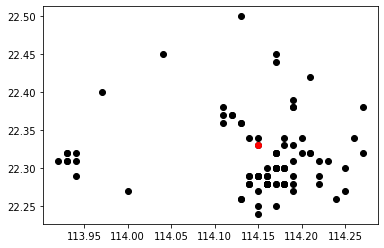

In [60]:
plt.scatter(y=dtf["y"], x=dtf["x"], color="black")
plt.scatter(y=start[0], x=start[1], color="red")
plt.show()

In [61]:
'''
Creates a map with folium.
:parameter
    :param dtf: pandas
    :param (y,x): str - columns with (latitude, longitude)
    :param starting_point: list - (latitude, longitude)
    :param tiles: str - "cartodbpositron", "OpenStreetMap", "Stamen Terrain", "Stamen Toner"
    :param popup: str - column with text to popup if clicked, if None there is no popup
    :param size: str - column with size variable, if None takes size=5
    :param color: str - column with color variable, if None takes default color
    :param lst_colors: list - list with multiple colors to use if color column is not None, if not given it generates randomly
    :param marker: str - column with marker variable, takes up to 7 unique values
:return
    map object to display
'''
def plot_map(dtf, y, x, start, zoom=12, tiles="cartodbpositron", popup=None, size=None, color=None, legend=False, lst_colors=None, marker=None):
    data = dtf.copy()

    ## create columns for plotting
    if color is not None:
        lst_elements = sorted(list(dtf[color].unique()))
        lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))] if lst_colors is None else lst_colors
        data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

    if size is not None:
        scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
        data["size"] = scaler.fit_transform(data[size].values.reshape(-1,1)).reshape(-1)

    ## map
    map_ = folium.Map(location=start, tiles=tiles, zoom_start=zoom)

    if (size is not None) and (color is None): 
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=row["size"]).add_to(map_), axis=1)
    elif (size is None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=5).add_to(map_), axis=1)
    elif (size is not None) and (color is not None):
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color=row["color"], fill=True, radius=row["size"]).add_to(map_), axis=1)
    else:
        data.apply(lambda row: folium.CircleMarker(location=[row[y],row[x]], popup=row[popup],
                                                   color='#3186cc', fill=True, radius=5).add_to(map_), axis=1)
    
    ## tiles
    layers = ["cartodbpositron", "openstreetmap", "Stamen Terrain", 
              "Stamen Water Color", "Stamen Toner", "cartodbdark_matter"]
    for tile in layers:
        folium.TileLayer(tile).add_to(map_)
    folium.LayerControl(position='bottomright').add_to(map_)
    
    ## legend
    if (color is not None) and (legend is True):
        legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
        for i in lst_elements:
            legend_html = legend_html+"""&nbsp;<i class="fa fa-circle fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+""""></i>&nbsp;"""+str(i)+"""<br>"""
        legend_html = legend_html+"""</div>"""
        map_.get_root().html.add_child(folium.Element(legend_html))
    
    ## add marker
    if marker is not None:
        lst_elements = sorted(list(dtf[marker].unique()))
        lst_colors = ["black","red","blue","green","pink","orange","gray"]  #7
        ### too many values, can't mark
        if len(lst_elements) > len(lst_colors):
            raise Exception("marker has uniques > "+str(len(lst_colors)))
        ### binary case (1/0): mark only 1s
        elif len(lst_elements) == 2:
            data[data[marker]==lst_elements[1]].apply(lambda row: folium.Marker(location=[row[y],row[x]], popup=row[marker], draggable=False, 
                                                                                icon=folium.Icon(color=lst_colors[0])).add_to(map_), axis=1) 
        ### normal case: mark all values
        else:
            for i in lst_elements:
                data[data[marker]==i].apply(lambda row: folium.Marker(location=[row[y],row[x]], popup=row[marker], draggable=False, 
                                                                      icon=folium.Icon(color=lst_colors[lst_elements.index(i)])).add_to(map_), axis=1)
    
    ## full screen
    plugins.Fullscreen(position="topright", title="Expand", title_cancel="Exit", force_separate_button=True).add_to(map_)
    return map_

In [62]:
map_ = plot_map(dtf, y="y", x="x", start=start, zoom=11, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black", "red"])
map_

In [63]:
for i in range(len(dtf)):
    points = [start, dtf[["y","x"]].iloc[i].tolist()]
    folium.PolyLine(points, color="red", weight=0.5, opacity=0.5).add_to(map_)
map_

### 1 - Shortest Path (between 2 locations)

###### Create Graph

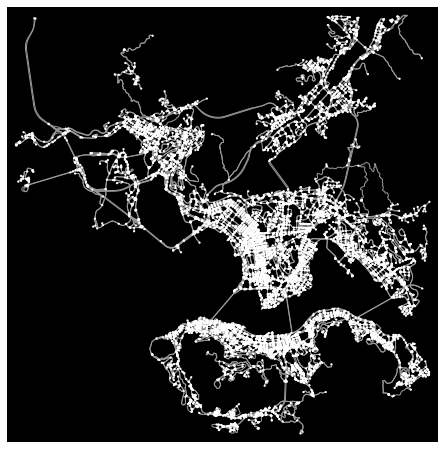

In [64]:
# Create network graph
G = ox.graph_from_point(start, dist=10000, network_type="drive")  #'drive', 'bike', 'walk'
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

fig, ax = ox.plot_graph(G, bgcolor="black", node_size=5, node_color="white", figsize=(16,8))

In [65]:
[i for i in G.nodes()][:10]

[24533064,
 26411640,
 26411641,
 26412251,
 30747332,
 30747334,
 32899260,
 33004487,
 33004488,
 33004530]

In [66]:
# geo-dataframe (nodes)
print("nodes:", len(G.nodes()))
ox.graph_to_gdfs(G, nodes=True, edges=False).reset_index().head(3)

nodes: 9568


osmid          y           x  street_count  ref highway   
0  24533064  22.276527  114.173172             3  NaN     NaN  \
1  26411640  22.250336  114.169964             3  NaN     NaN   
2  26411641  22.250545  114.171056             3  NaN     NaN   

                     geometry  
0  POINT (114.17317 22.27653)  
1  POINT (114.16996 22.25034)  
2  POINT (114.17106 22.25054)

In [67]:
# geo-dataframe (links)
print("links:", len(G.edges()))
ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index().head(3)

links: 17498


u           v  key      osmid  oneway lanes                   name   
0  24533064  1618530627    0  743072632    True     2     莊士敦道 Johnston Road  \
1  24533064   297187423    0  567856161   False     2     莊士敦道 Johnston Road   
2  26411640  3698862626    0   26560287    True     1  海洋公園道 Ocean Park Road   

          highway reversed   length  ...   
0        tertiary    False   38.526  ...  \
1        tertiary    False   30.191  ...   
2  secondary_link    False  130.623  ...   

                                            geometry  ref maxspeed junction   
0  LINESTRING (114.17317 22.27653, 114.17280 22.2...  NaN      NaN      NaN  \
1  LINESTRING (114.17317 22.27653, 114.17332 22.2...  NaN      NaN      NaN   
2  LINESTRING (114.16996 22.25034, 114.17012 22.2...  NaN      NaN      NaN   

  bridge area access tunnel width service  
0    NaN  NaN    NaN    NaN   NaN     NaN  
1    NaN  NaN    NaN    NaN   NaN     NaN  
2    NaN  NaN    NaN    NaN   NaN     NaN  

[3 rows x 22 columns]

###### Dijkstra Algorithm

In [68]:
end = dtf[dtf["id"]==68][["y","x"]].values[0]
print("locations: from", start, "--> to", end)

locations: from [ 22.33 114.15] --> to [ 22.34 114.15]


In [69]:
# find the nearest node to the start/end location
start_node = ox.distance.nearest_nodes(G, start[1], start[0])
end_node = ox.distance.nearest_nodes(G, end[1], end[0])
print("nodes: from", start_node, "--> to", end_node)

nodes: from 493883072 --> to 480679404


18 nodes --> [493883072, 289293755, 289294146, 289294087, 275816026, 289329905, 1182677821, 1645492788, 1645492916, 1191992694, 5101419365, 332257610, 999331442, 1191992696, 480679312, 999331647, 1641766800, 480679404]


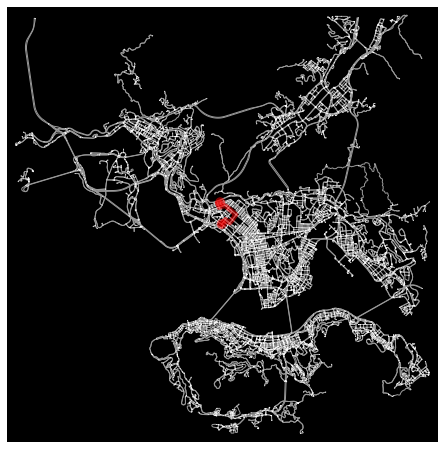

In [70]:
# calculate shortest path
path_lenght = nx.shortest_path(G, source=start_node, target=end_node, method='dijkstra', weight='lenght')
print(len(path_lenght), "nodes -->", path_lenght)

# plot on the graph
fig, ax = ox.plot_graph_route(G, path_lenght, route_color="red", route_linewidth=5,
                              node_size=1, bgcolor='black', node_color="white",
                              figsize=(16,8))

21 nodes --> [493883072, 289293755, 289294146, 289295423, 289295628, 289295766, 289295767, 289295566, 5101376323, 4844635141, 289295620, 274244744, 1641766635, 1641766639, 1641766654, 999331442, 1191992696, 480679312, 999331647, 1641766800, 480679404]


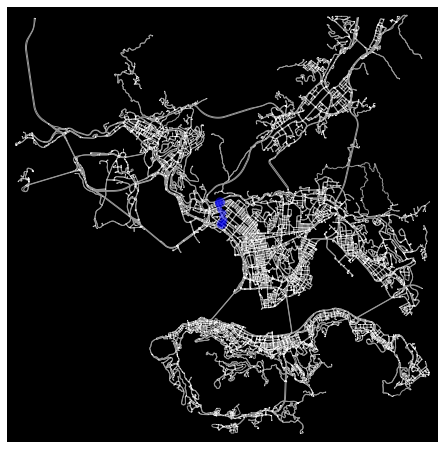

In [71]:
# calculate shortest path
path_time = nx.shortest_path(G, source=start_node, target=end_node, method='dijkstra', weight='travel_time')
print(len(path_time), "nodes -->", path_time)

# plot on the graph
fig, ax = ox.plot_graph_route(G, path_time, route_color="blue", route_linewidth=5, 
                              node_size=1, bgcolor='black', node_color="white", 
                              figsize=(16,8))

Red  route: 2.41 km | 2.78 min
Blue route: 1.49 km | 1.8 min


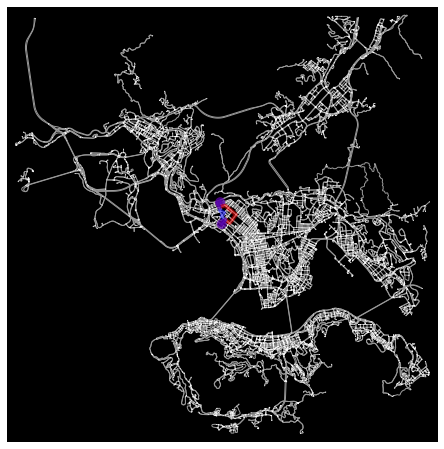

In [72]:
# compare the two routes
print('Red  route:', 
      round(sum(ox.utils_graph.get_route_edge_attributes(G,path_lenght,'length'))/1000, 2), 
      'km |', 
      round(sum(ox.utils_graph.get_route_edge_attributes(G,path_lenght,'travel_time'))/60, 2), 
      'min')

print('Blue route:', 
      round(sum(ox.utils_graph.get_route_edge_attributes(G,path_time,'length'))/1000, 2), 
      'km |', 
      round(sum(ox.utils_graph.get_route_edge_attributes(G,path_time,'travel_time'))/60, 2), 
      'min')

# plot on the graph
fig, ax = ox.plot_graph_routes(G, routes=[path_lenght, path_time], 
                              route_colors=["red","blue"], route_linewidth=5, 
                              node_size=1, bgcolor='black', node_color="white", 
                              figsize=(16,8))

In [73]:
# plot on the map
map_ = plot_map(dtf, y="y", x="x", start=start, zoom=12, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black","red"])

ox.plot_route_folium(G, route=path_lenght, route_map=map_, color="red", weight=1)
ox.plot_route_folium(G, route=path_time, route_map=map_, color="blue", weight=1)
map_

### 2 - Animation

In [74]:
## setup
#key = "pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w"
#px.set_mapbox_access_token(key)

###### Single Path

In [75]:
def df_animation_single_path(G, path):
    lst_start, lst_end = [],[]
    start_x, start_y = [],[]
    end_x, end_y = [],[]
    lst_length, lst_time = [],[]

    for a,b in zip(path[:-1], path[1:]):
        lst_start.append(a)
        lst_end.append(b)
        lst_length.append(round(G.edges[(a,b,0)]['length']))
        lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
        start_x.append(G.nodes[a]['x'])
        start_y.append(G.nodes[a]['y'])
        end_x.append(G.nodes[b]['x'])
        end_y.append(G.nodes[b]['y'])

    df = pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), 
                       columns=["start","end","start_x","start_y","end_x","end_y","length","travel_time"]
                     ).reset_index().rename(columns={"index":"id"})
    return df

In [76]:
print("nodes: from", start_node, "--> to", end_node)

df = df_animation_single_path(G, path_time)
df.head()

nodes: from 493883072 --> to 480679404


id      start        end     start_x    start_y       end_x      end_y   
0   0  493883072  289293755  114.150598  22.330550  114.151500  22.331566  \
1   1  289293755  289294146  114.151500  22.331566  114.152190  22.332349   
2   2  289294146  289295423  114.152190  22.332349  114.151381  22.332983   
3   3  289295423  289295628  114.151381  22.332983  114.150783  22.333581   
4   4  289295628  289295766  114.150783  22.333581  114.150609  22.333969   

   length  travel_time  
0     146           12  
1     112           10  
2     109            8  
3      91            6  
4      47            3

In [77]:
def plot_animation(df, start_node, end_node):
    ## create start/end df
    df_start = df[df["start"] == start_node]
    df_end = df[df["end"] == end_node]
    
    ## create basic map
    fig = px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=1000, height=800, 
                            animation_frame="id", mapbox_style="carto-positron")
    ## add driver
    fig.data[0].marker = {"size":12}
    ## add start point
    fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
    fig.data[1].marker = {"size":15, "color":"red"}
    ## add end point
    fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
    fig.data[2].marker = {"size":15, "color":"green"}
    ## add route
    fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])
    return fig

In [78]:
plot_animation(df, start_node, end_node)

###### Multiple Path

In [79]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df = pd.DataFrame()
    for path in lst_paths:
        lst_start, lst_end = [],[]
        start_x, start_y = [],[]
        end_x, end_y = [],[]
        lst_length, lst_time = [],[]

        for a,b in zip(path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])

        tmp = pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), 
                           columns=["start","end","start_x","start_y","end_x","end_y","length","travel_time"]
                          )
        df = pd.concat([df, tmp], ignore_index=(not parallel))

    df = df.reset_index().rename(columns={"index":"id"})
    return df

In [80]:
first_node, last_node = start_node, end_node
lst_paths = [path_time, path_lenght]
print(len(lst_paths), "paths,", sum(len(i) for i in lst_paths), "nodes:", first_node, "...", last_node)

df = df_animation_multiple_path(G, lst_paths, parallel=True)
df.tail()

2 paths, 39 nodes: 493883072 ... 480679404


id       start         end     start_x    start_y       end_x      end_y   
32  12   999331442  1191992696  114.149414  22.337676  114.149364  22.337792  \
33  13  1191992696   480679312  114.149364  22.337792  114.149004  22.338645   
34  14   480679312   999331647  114.149004  22.338645  114.148794  22.339156   
35  15   999331647  1641766800  114.148794  22.339156  114.148567  22.339701   
36  16  1641766800   480679404  114.148567  22.339701  114.149878  22.339942   

    length  travel_time  
32      14            1  
33     102            7  
34      61            4  
35      65            5  
36     158           12

In [81]:
plot_animation(df, first_node, last_node)

### 3 - Preprocessing

###### Distance Matrix

In [82]:
dtf["node"] = dtf[["y","x"]].apply(lambda x: ox.distance.nearest_nodes(G,x[1],x[0]), axis=1)
dtf = dtf.drop_duplicates("node", keep='first')
dtf.head()

id       City                                     Street Address      y   
0   0  Hong Kong  Shop No.101, 1st Floor, Liberte Place, 8, 33 L...  22.33  \
1   1  Hong Kong  Shop B, Ground Floor, 50 Connaught Central, Ce...  22.29   
2   2  Hong Kong         Office Lobby, G/F Exchange Square, Central  22.28   
3   3  Hong Kong  Shop 247, Level 2, Moko 193 Prince Edward Rd W...  22.32   
4   4  Hong Kong  Shop NO. 106 1/F, East Point City, No. 8, Chun...  22.32   

        x  base        node  
0  114.15     1   493883072  
1  114.16     0  4615742665  
2  114.16     0  4361219227  
3  114.17     0   308473193  
4  114.27     0   919340746

In [83]:
def f(a,b):
    try:
        d = nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d = np.nan
    return d

distance_matrix = np.asarray([[f(a,b) for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix = pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)
distance_matrix.head()

493883072    4615742665   4361219227   308473193    919340746     
493883072           0.0        461.9        540.3        176.4          NaN  \
4615742665        526.6          0.0        110.9        507.6          NaN   
4361219227        526.7         95.4          0.0        507.7          NaN   
308473193         195.0        423.1        491.0          0.0          NaN   
919340746         815.5        832.1        809.6        680.0          0.0   

            1002550791   316735801    1271129005   5103531349   2280300926    
493883072         581.8       1018.7        314.4        401.2        261.6  \
4615742665        205.2        676.3        699.4        479.8        549.0   
4361219227        204.0        706.1        699.5        482.0        551.2   
308473193         430.7        867.6        451.1        228.2        146.1   
919340746         705.9        769.0       1008.1        587.2        599.5   

            ...  564643046    345538787    4850194903   4775210721    
493883072   ...        757.3        769.7        564.4        315.5  \
4615742665  ...        428.0        572.1        277.2        609.1   
4361219227  ...        407.9        570.4        278.6        611.3   
308473193   ...        606.2        730.9        413.3        206.2   
919340746   ...        941.2       1106.0        713.7        584.0   

            1653118849   7235049604   474728810    10199917434  1623825285    
493883072         836.8        736.2        452.3        691.3        679.9  \
4615742665        494.4        393.8        706.8        493.7        361.8   
4361219227        524.2        423.6        709.0        492.0        349.2   
308473193         685.7        585.1        303.8        652.5        528.8   
919340746         587.1        486.5        434.7       1199.2        819.3   

            1685958990   
493883072         827.4  
4615742665        461.7  
4361219227        440.7  
308473193         788.6  
919340746        1160.4  

[5 rows x 52 columns]

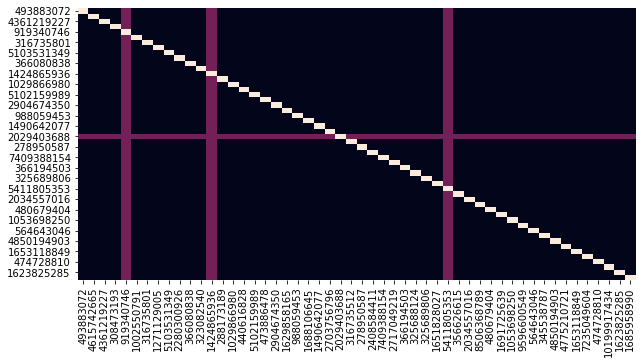

In [84]:
heatmap = distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col] = heatmap[col].apply(lambda x: 0.3 if pd.isnull(x) else  #nan -> purple
                                               (0.7 if np.isinf(x) else   #inf -> orange
                                               (0 if x!=0 else 1) ))      # 0  -> white

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0, vmax=1, cbar=False, ax=ax)
plt.show()

In [85]:
## NAs
distance_matrix = distance_matrix.T.fillna(distance_matrix.mean(axis=1)).T
distance_matrix.head()

493883072    4615742665   4361219227   308473193    919340746     
493883072           0.0        461.9        540.3        176.4   567.163265  \
4615742665        526.6          0.0        110.9        507.6   632.877551   
4361219227        526.7         95.4          0.0        507.7   634.414286   
308473193         195.0        423.1        491.0          0.0   526.234694   
919340746         815.5        832.1        809.6        680.0     0.000000   

            1002550791   316735801    1271129005   5103531349   2280300926    
493883072         581.8       1018.7        314.4        401.2        261.6  \
4615742665        205.2        676.3        699.4        479.8        549.0   
4361219227        204.0        706.1        699.5        482.0        551.2   
308473193         430.7        867.6        451.1        228.2        146.1   
919340746         705.9        769.0       1008.1        587.2        599.5   

            ...  564643046    345538787    4850194903   4775210721    
493883072   ...        757.3        769.7        564.4        315.5  \
4615742665  ...        428.0        572.1        277.2        609.1   
4361219227  ...        407.9        570.4        278.6        611.3   
308473193   ...        606.2        730.9        413.3        206.2   
919340746   ...        941.2       1106.0        713.7        584.0   

            1653118849   7235049604   474728810    10199917434  1623825285    
493883072         836.8        736.2        452.3        691.3        679.9  \
4615742665        494.4        393.8        706.8        493.7        361.8   
4361219227        524.2        423.6        709.0        492.0        349.2   
308473193         685.7        585.1        303.8        652.5        528.8   
919340746         587.1        486.5        434.7       1199.2        819.3   

            1685958990   
493883072         827.4  
4615742665        461.7  
4361219227        440.7  
308473193         788.6  
919340746        1160.4  

[5 rows x 52 columns]

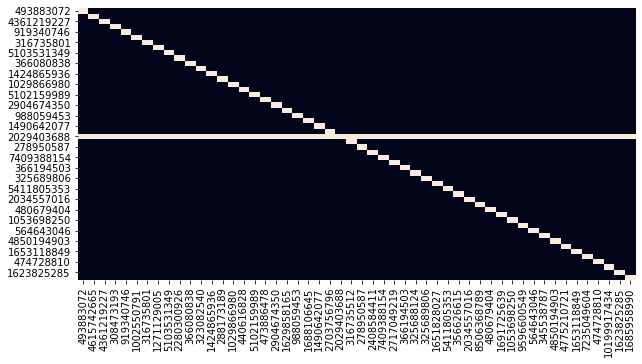

In [86]:
heatmap = distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col] = heatmap[col].apply(lambda x: 0.3 if pd.isnull(x) else  #nan -> purple
                                               (0.7 if np.isinf(x) else   #inf -> orange
                                               (0 if x!=0 else 1) ))      # 0  -> white

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0, vmax=1, cbar=False, ax=ax)
plt.show()

### 3 - Traveling Salesman Problem (Shortest Route)

###### Model

In [181]:
## Business parameters
drivers = 1

In [182]:
lst_nodes = dtf["node"].tolist()
print("start:", start_node, "| tot locations to visit:", len(lst_nodes)-1, "| drivers:", drivers)

start: 493883072 | tot locations to visit: 51 | drivers: 1


In [183]:
len(distance_matrix.iloc[1])

52

In [184]:
## model
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model = pywrapcp.RoutingModel(manager)

## add distance (cost)
def get_distance(from_index, to_index):
    #from_node = manager.IndexToNode(from_index)
    #to_node = manager.IndexToNode(to_index)
    return distance_matrix.iloc[from_index,to_index]

distance = model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

## set strategy to minimize cost (distance)
parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
solution = model.SolveWithParameters(parameters)

## solution
index = model.Start(0)
print('Route for driver:')
route_idx, route_distance = [], 0
while not model.IsEnd(index):
    route_idx.append( manager.IndexToNode(index) ) 
    previous_index = index
    index = solution.Value( model.NextVar(index) )
    ### update distance
    try:
        route_distance += get_distance(previous_index, index)
    except:
        route_distance += model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f'Total distance: {round(route_distance/1000,2)} km')
print(f'Nodes visited: {len(route_idx)}')

Route for driver:
[0, 15, 38, 3, 9, 45, 33, 48, 21, 17, 8, 14, 20, 26, 28, 13, 1, 2, 10, 5, 44, 37, 47, 46, 25, 6, 27, 39, 50, 42, 16, 43, 49, 35, 51, 34, 12, 30, 29, 36, 22, 31, 32, 11, 23, 7, 19, 18, 24, 41, 4, 40]
Total distance: 16.3 km
Nodes visited: 52


In [185]:
print("Route for driver (nodes):")
lst_route = [lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[493883072, 440616828, 480679404, 308473193, 2280300926, 4775210721, 1651828027, 474728810, 1688106645, 473886478, 5103531349, 1029866980, 988059453, 278950587, 7409388154, 288173189, 4615742665, 4361219227, 366080838, 1002550791, 4850194903, 8506368789, 7235049604, 1653118849, 316735512, 316735801, 2408584411, 1691725639, 1623825285, 564643046, 5102159989, 345538787, 10199917434, 356626615, 1685958990, 5411805353, 1424865936, 366194503, 2717049219, 2034557016, 1490642077, 325688124, 325689806, 323082540, 2703756796, 1271129005, 1629858165, 2904674350, 2029403688, 9596600549, 919340746, 1053698250]


###### Plot

In [188]:
# Get path between nodes
def get_path_between_nodes(lst_route):
    lst_paths = []
    for i in range(len(lst_route)):
        ## get node and next-node
        try:
            a,b = lst_route[i], lst_route[i+1]
        except:
            break
        ## get path
        try:
            path = nx.shortest_path(G, source=a, target=b, method='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

In [189]:
lst_paths = get_path_between_nodes(lst_route)
len(lst_paths)

47

In [190]:
# plot on the map
map_ = plot_map(dtf, y="y", x="x", start=start, zoom=12, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black","red"])

for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map_, color="blue", weight=1)
map_

In [191]:
# animation
first_node, last_node = lst_paths[0][0], lst_paths[-1][-1]
print(len(lst_paths), "paths,", sum(len(i) for i in lst_paths), "nodes:", first_node, "...", last_node)

df = df_animation_multiple_path(G, lst_paths, parallel=False)
plot_animation(df, first_node, last_node)

47 paths, 1341 nodes: 493883072 ... 1053698250


### 4 - Vehicle Routing Problem

###### Model

In [192]:
## Business parameters
drivers = 3
driver_capacities = [20,20,20]
demands = [0] + [1]*(len(lst_nodes)-1)

In [193]:
print("start:", start_node, "| tot locations to visit:", len(lst_nodes)-1, "| drivers:", drivers)

start: 493883072 | tot locations to visit: 51 | drivers: 3


In [194]:
len(distance_matrix.iloc[1])

52

In [195]:
## model
manager = pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model = pywrapcp.RoutingModel(manager)

## add distance (cost)
def get_distance(from_index, to_index):
    #from_node = manager.IndexToNode(from_index)
    #to_node = manager.IndexToNode(to_index)
    return distance_matrix.iloc[from_index,to_index]

distance = model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

## add capacity (costraint)
def get_demand(from_index):
    from_node = manager.IndexToNode(from_index)
    return demands[from_node]

demand = model.RegisterUnaryTransitCallback(get_demand)
model.AddDimensionWithVehicleCapacity(demand, slack_max=0, 
                                      vehicle_capacities=driver_capacities, 
                                      fix_start_cumul_to_zero=True, 
                                      name='Capacity')

## add limited distance (costraint)
name = 'Distance'
model.AddDimension(distance, slack_max=0, capacity=1000, 
                   fix_start_cumul_to_zero=True, name=name)
distance_dimension = model.GetDimensionOrDie(name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

## set strategy to minimize cost (distance)
parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
solution = model.SolveWithParameters(parameters)

## solution
dic_routes_idx, total_distance, total_load = {}, 0, 0
for driver in range(drivers):
    print(f'Route for driver {driver}:')
    index = model.Start(driver)
    route_idx, route_distance, route_load = [], 0, 0
    while not model.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route_idx.append( manager.IndexToNode(index) )
        previous_index = index
        index = solution.Value( model.NextVar(index) )
        ### update distance
        try:
            route_distance += get_distance(previous_index, index)
        except:
            route_distance += model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=driver)
        ### update load
        route_load += demands[node_index]
        
    route_idx.append( manager.IndexToNode(index) )
    print(route_idx)
    dic_routes_idx[driver] = route_idx
    print(f'distance: {round(route_distance/1000,2)} km')
    print(f'load: {round(route_load,2)}', "\n")
    total_distance += route_distance
    total_load += route_load
    
print(f'Total distance: {round(total_distance/1000,2)} km')
print(f'Total load: {total_load}')

Route for driver 0:
[0, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
distance: 6.32 km
load: 11 

Route for driver 1:
[0, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 0]
distance: 14.22 km
load: 20 

Route for driver 2:
[0, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 0]
distance: 15.14 km
load: 20 

Total distance: 35.67 km
Total load: 51


In [196]:
dic_route = {}
for k,v in dic_routes_idx.items():
    print(f"Route for driver {k} (nodes):")
    dic_route[k] = [lst_nodes[i] for i in v]
    print(dic_route[k], "\n")

Route for driver 0 (nodes):
[493883072, 323082540, 366080838, 2280300926, 5103531349, 1271129005, 316735801, 1002550791, 919340746, 308473193, 4361219227, 4615742665, 493883072] 

Route for driver 1 (nodes):
[493883072, 325688124, 366194503, 2717049219, 7409388154, 2408584411, 278950587, 316735512, 2029403688, 2703756796, 1490642077, 1688106645, 988059453, 1629858165, 2904674350, 473886478, 5102159989, 440616828, 1029866980, 288173189, 1424865936, 493883072] 

Route for driver 2 (nodes):
[493883072, 1685958990, 1623825285, 10199917434, 474728810, 7235049604, 1653118849, 4775210721, 4850194903, 345538787, 564643046, 9596600549, 1053698250, 1691725639, 480679404, 8506368789, 2034557016, 356626615, 5411805353, 1651828027, 325689806, 493883072] 



###### Plot

In [197]:
dic_paths = {k:get_path_between_nodes(v) for k,v in dic_route.items()}
len(dic_paths)

3

In [201]:
# plot on the map
map_ = plot_map(dtf, y="y", x="x", start=start, zoom=11, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black","red"])

lst_colors = ["red","green","blue"]
for k,v in dic_paths.items():
    for path in v:
        ox.plot_route_folium(G, route=path, route_map=map_, color=lst_colors[k], weight=1)
map_

######  Animation

In [208]:
# animation
first_node, last_node = dic_paths[0][0], dic_paths[2][-1]

lst_paths = [[x for lst in v for x in lst] for v in dic_paths.values()]

df = df_animation_multiple_path(G, lst_paths, parallel=True)
plot_animation(df, first_node, last_node)

ValueError: ('Lengths must match to compare', (563,), (51,))

### 5 - Reinforcement Learning

###### SubGraph 

In [97]:
print("from", start_node, "--> to", end_node)

from 493883072 --> to 480679404


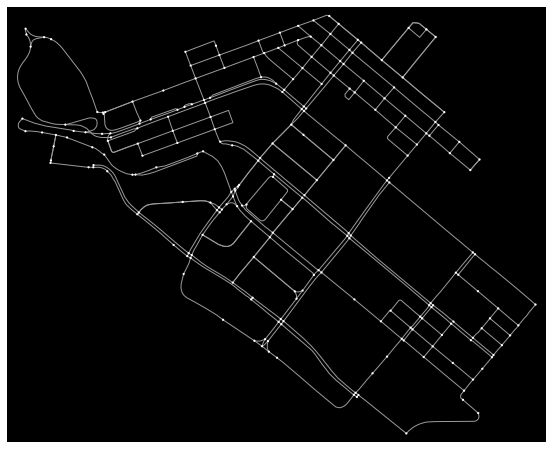

In [111]:
paths_generator = nx.all_simple_paths(G, source=start_node, target=end_node, cutoff=30)  #<--max number of nodes
subG = G.subgraph({node for path in paths_generator for node in path})

fig, ax = ox.plot_graph(subG, bgcolor="black", node_size=5, node_color="white", figsize=(16,8))

In [112]:
# distance between all the nodes
distance_matrix = pd.DataFrame(nx.floyd_warshall_numpy(subG, weight="travel_time"), 
                               columns=subG.nodes(), index=subG.nodes())
distance_matrix = distance_matrix.replace([np.inf, -np.inf], np.nan)
distance_matrix.head()

289295876   4844635141  1645493254  999331337   1194385422   
289295876          0.0        57.0       148.0       102.2        75.7  \
4844635141        60.6         0.0       111.8        53.9        22.1   
1645493254       199.2       138.6         0.0       192.5       160.7   
999331337        201.5       140.9        94.4         0.0       163.0   
1194385422        76.8        16.2       109.2        70.1         0.0   

            1161205777  6389573139  289295904   1194385446  1645492775  ...   
289295876         73.9       146.3        56.4        62.6       179.3  ...  \
4844635141        74.2       110.1        73.5         9.0       122.3  ...   
1645493254       212.8       198.6       212.1       147.6       240.1  ...   
999331337         20.3        92.7        20.8       149.9       242.4  ...   
1194385422        90.4       107.5        89.7        25.2       119.7  ...   

            1645493211  1645493214  1641766884  999331300   1161206758   
289295876        150.1       148.1       125.7       121.8        79.3  \
4844635141       113.9       111.9        68.7        64.8        79.6   
1645493254         8.0         6.0       119.3       153.3       218.2   
999331337         96.5        94.5       140.9       155.6        25.7   
1194385422       111.3       109.3        66.1        62.2        95.8   

            999331306   480679404   1191992814  1641766386  991294970   
289295876        123.6       121.2        88.8       155.7       134.8  
4844635141        66.6        64.2        31.8        98.7        81.2  
1645493254       105.1        84.7       107.8       216.5       205.7  
999331337        126.7       106.3       110.1       218.8       208.0  
1194385422        64.0        61.6        29.2        96.1        85.3  

[5 rows x 237 columns]

In [113]:
# Rewards
R = -1*distance_matrix
R.head()

289295876   4844635141  1645493254  999331337   1194385422   
289295876         -0.0       -57.0      -148.0      -102.2       -75.7  \
4844635141       -60.6        -0.0      -111.8       -53.9       -22.1   
1645493254      -199.2      -138.6        -0.0      -192.5      -160.7   
999331337       -201.5      -140.9       -94.4        -0.0      -163.0   
1194385422       -76.8       -16.2      -109.2       -70.1        -0.0   

            1161205777  6389573139  289295904   1194385446  1645492775  ...   
289295876        -73.9      -146.3       -56.4       -62.6      -179.3  ...  \
4844635141       -74.2      -110.1       -73.5        -9.0      -122.3  ...   
1645493254      -212.8      -198.6      -212.1      -147.6      -240.1  ...   
999331337        -20.3       -92.7       -20.8      -149.9      -242.4  ...   
1194385422       -90.4      -107.5       -89.7       -25.2      -119.7  ...   

            1645493211  1645493214  1641766884  999331300   1161206758   
289295876       -150.1      -148.1      -125.7      -121.8       -79.3  \
4844635141      -113.9      -111.9       -68.7       -64.8       -79.6   
1645493254        -8.0        -6.0      -119.3      -153.3      -218.2   
999331337        -96.5       -94.5      -140.9      -155.6       -25.7   
1194385422      -111.3      -109.3       -66.1       -62.2       -95.8   

            999331306   480679404   1191992814  1641766386  991294970   
289295876       -123.6      -121.2       -88.8      -155.7      -134.8  
4844635141       -66.6       -64.2       -31.8       -98.7       -81.2  
1645493254      -105.1       -84.7      -107.8      -216.5      -205.7  
999331337       -126.7      -106.3      -110.1      -218.8      -208.0  
1194385422       -64.0       -61.6       -29.2       -96.1       -85.3  

[5 rows x 237 columns]

In [114]:
Q = pd.DataFrame(np.zeros(shape=(len(subG.nodes()),len(subG.nodes()))), 
                 columns=subG.nodes(), index=subG.nodes())
Q.head()

289295876   4844635141  1645493254  999331337   1194385422   
289295876          0.0         0.0         0.0         0.0         0.0  \
4844635141         0.0         0.0         0.0         0.0         0.0   
1645493254         0.0         0.0         0.0         0.0         0.0   
999331337          0.0         0.0         0.0         0.0         0.0   
1194385422         0.0         0.0         0.0         0.0         0.0   

            1161205777  6389573139  289295904   1194385446  1645492775  ...   
289295876          0.0         0.0         0.0         0.0         0.0  ...  \
4844635141         0.0         0.0         0.0         0.0         0.0  ...   
1645493254         0.0         0.0         0.0         0.0         0.0  ...   
999331337          0.0         0.0         0.0         0.0         0.0  ...   
1194385422         0.0         0.0         0.0         0.0         0.0  ...   

            1645493211  1645493214  1641766884  999331300   1161206758   
289295876          0.0         0.0         0.0         0.0         0.0  \
4844635141         0.0         0.0         0.0         0.0         0.0   
1645493254         0.0         0.0         0.0         0.0         0.0   
999331337          0.0         0.0         0.0         0.0         0.0   
1194385422         0.0         0.0         0.0         0.0         0.0   

            999331306   480679404   1191992814  1641766386  991294970   
289295876          0.0         0.0         0.0         0.0         0.0  
4844635141         0.0         0.0         0.0         0.0         0.0  
1645493254         0.0         0.0         0.0         0.0         0.0  
999331337          0.0         0.0         0.0         0.0         0.0  
1194385422         0.0         0.0         0.0         0.0         0.0  

[5 rows x 237 columns]

###### Train

In [115]:
def next_action(Q, current_state, actions_space, explore_rate=0.5):            
    ## explore: select a random action
    if np.random.uniform(0,1) < explore_rate:
        new_state = np.random.choice(actions_space)
    ## exploit: select the action with max q_value
    else:
        current_qs = Q.loc[current_state]
        action = np.argmax(current_qs)
        new_state = current_qs.index[action]
    return new_state

In [116]:
def decay_exploration(explore_rate, min_eploration=0.001, explore_decay=0.99):
    ## reduce the exploration rate 
    if explore_rate > min_eploration:
        epsilon_decayed = explore_rate * explore_decay
        explore_rate = max(min_eploration, epsilon_decayed)
    ## keep minimun exporation
    else:
        explore_rate = explore_rate
    return explore_rate

In [117]:
def update_Q(Q, current_state, new_state, reward, goal, discount_rate=0.8, learning_rate=0.1):
    ## comupte new_q_value
    if not goal:
        max_q_value = np.max(Q.loc[new_state])
        current_q_value = Q.loc[current_state, new_state]
        new_q_value = ((1-learning_rate)*current_q_value)+(learning_rate*(reward+(discount_rate*max_q_value)))
    ## reward for reaching the goal
    else:
        new_q_value = 100
    ## update
    Q.loc[current_state, new_state] = new_q_value
    return Q

In [118]:
# train
current_state, destination = start_node, end_node
explore_rate, reached_goal = 0.5, 0
n_iter = 10**len(str(len(R)**3))

for i in tqdm(range(n_iter)):
    ## do action
    actions_space = [i for i in nx.ego_graph(subG, n=current_state, radius=1, center=False)]
    new_state = next_action(Q, current_state, actions_space, explore_rate=explore_rate)
    ## get reward
    reward = R.loc[current_state, new_state]
    goal = (new_state == destination)
    if goal:
        reached_goal += 1
    ## update
    Q = update_Q(Q, current_state, new_state, reward, goal=goal, discount_rate=0.8, learning_rate=0.1)
    current_state = new_state
    explore_rate = decay_exploration(explore_rate, min_eploration=0.001, explore_decay=0.99)

print(f"goal reached {reached_goal} times")
Q.head()

  0%|          | 276824/100000000 [02:31<15:11:51, 1822.71it/s]


KeyboardInterrupt: 

###### Test

In [106]:
# predict
path_rl = [start_node]
goal = False

while not goal:
    action = np.argmax(Q.loc[current_state])
    new_state = Q.loc[current_state].index[action]
    path_rl.append(new_state)
    goal = (new_state == destination)
    current_state = new_state

path_rl

KeyboardInterrupt: 

In [ ]:
# plot on the map
map_ = plot_map(dtf, y="y", x="x", start=start, zoom=12, 
                tiles="cartodbpositron", popup="id", 
                color="base", lst_colors=["black","red"])

ox.plot_route_folium(G, route=path_rl, route_map=map_, color="green", weight=1)
ox.plot_route_folium(G, route=path_time, route_map=map_, color="blue", weight=1)
map_